In [1]:
# Import all the packages
import os
import time
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !rm -r /content/__MACOSX
# !rm -r /content/non-vehicles
# !rm -r /content/vehicles
# !rm -r /content/drive/MyDrive/HOG_CNN/data/train
# !rm -r /content/drive/MyDrive/HOG_CNN/data/test

In [4]:
!unzip /content/drive/MyDrive/videoAnalytics/data/vehicles.zip -d /content/drive/MyDrive/videoAnalytics/data/
!unzip /content/drive/MyDrive/videoAnalytics/data/non-vehicles.zip -d /content/drive/MyDrive/videoAnalytics/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/videoAnalytics/data/non-vehicles/Extras/extra5158.png  
  inflating: /content/drive/MyDrive/videoAnalytics/data/non-vehicles/Extras/extra5159.png  
  inflating: /content/drive/MyDrive/videoAnalytics/data/non-vehicles/Extras/extra516.png  
  inflating: /content/drive/MyDrive/videoAnalytics/data/non-vehicles/Extras/extra5160.png  
  inflating: /content/drive/MyDrive/videoAnalytics/data/non-vehicles/Extras/extra5161.png  
  inflating: /content/drive/MyDrive/videoAnalytics/data/non-vehicles/Extras/extra5162.png  
  inflating: /content/drive/MyDrive/videoAnalytics/data/non-vehicles/Extras/extra5163.png  
  inflating: /content/drive/MyDrive/videoAnalytics/data/non-vehicles/Extras/extra5164.png  
  inflating: /content/drive/MyDrive/videoAnalytics/data/non-vehicles/Extras/extra5165.png  
  inflating: /content/drive/MyDrive/videoAnalytics/data/non-vehicles/Extras/extra5166.png  
  inflating: /content/drive/My

In [5]:
def show_images_in_table (images, table_size, fig_size = (10, 10), cmap=None, titles=None):
    """Shows images in table
    Args:
        images (list): list of input images
        table_size (tuple): (cols count, rows count)
        fig_size (tuple): picture (size x, size y) in inches
        cmap (list): list of cmap parameters for each image
        titles (list): list of images titles
    """
    sizex = table_size [0]
    sizey = table_size [1]
    fig, imtable = plt.subplots (sizey, sizex, figsize = fig_size, squeeze=False)
    for j in range (sizey):
        for i in range (sizex):
            im_idx = i + j*sizex
            if (isinstance(cmap, (list, tuple))):
                imtable [j][i].imshow (images[im_idx], cmap=cmap[i])
            else:
                im = images[im_idx]
                if len(im.shape) == 3:
                    imtable [j][i].imshow (im)
                else:
                    imtable [j][i].imshow (im, cmap='gray')
            imtable [j][i].axis('off')
            if not titles is None:
                imtable [j][i].set_title (titles [im_idx], fontsize=32)

    plt.show ()

def plt_show_gray (image):
    """Shows gray image
    Args:
        image: image to show
    """
    plt.figure ()
    plt.imshow (image, cmap='gray')
    plt.show ()

def plt_show (image):
    """Shows color image in RGB format
    Args:
        image: image to show
    """
    plt.figure ()
    plt.imshow (image)
    plt.show ()

# Visualizations will be shown in the notebook.
%matplotlib inline

dataset has cars: 8792
none cars: 8968

Training Dataset - Cars


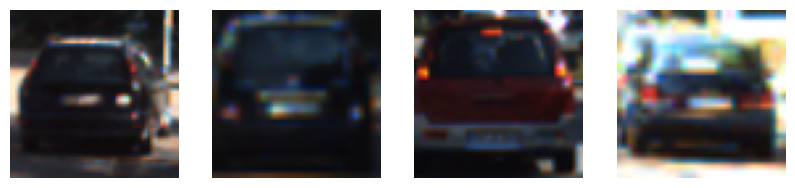


Training Dataset - Not-Cars


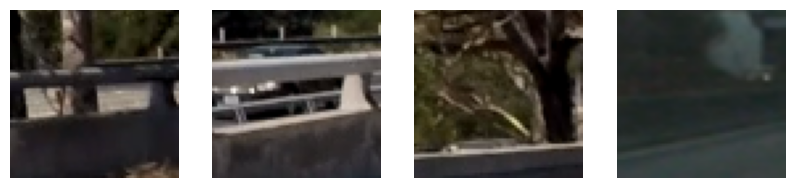

In [6]:
import random

# loading project dataset
# car images and none car images

# get vehicles and non-vehicles images from here
# https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
# https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip
# and extract into dataset directory
cars = glob.glob('/content/drive/MyDrive/videoAnalytics/data/vehicles/**/*.png', recursive=True)
notcars = glob.glob('/content/drive/MyDrive/videoAnalytics/data/non-vehicles/**/*.png', recursive=True)

# loading car images
car_image = [mpimg.imread(impath) for impath in cars]

# loading non car images
notcar_image = [mpimg.imread(impath) for impath in notcars]

car_image_count = len (car_image)
notcar_image_count = len (notcar_image)

print ('dataset has cars:', car_image_count)
print ('none cars:', notcar_image_count)

# show dataset images examples
car_images = [
    car_image [random.randint (0, car_image_count-1)],
    car_image [random.randint (0, car_image_count-1)],
    car_image [random.randint (0, car_image_count-1)],
    car_image [random.randint (0, car_image_count-1)]
]

non_car_images = [
    notcar_image [random.randint (0, notcar_image_count-1)],
    notcar_image [random.randint (0, notcar_image_count-1)],
    notcar_image [random.randint (0, notcar_image_count-1)],
    notcar_image [random.randint (0, notcar_image_count-1)]
]

print('')
print('Training Dataset - Cars')
show_images_in_table (car_images, (4, 1), fig_size=(10, 10))

print('')
print('Training Dataset - Not-Cars')
show_images_in_table (non_car_images, (4, 1), fig_size=(10, 10))

In [7]:
# parameters of feature extraction

color_space = 'GRAY' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

In [8]:
# HOG features and its visualization

from skimage.feature import hog
import math

def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    """Return HOG features and its visualization if needed
    Args:
        img (numpy.array): image for feature extraction
        orient (int): number of orientations
        pix_per_cell (int): number of pixels in HOG cell
        cell_per_block (int): number of HOG cells in block
        vis (boolean): default False, return visualization image as second return parameter
        feature_vec (boolean): default True, return features as vector
    Returns:
        features or features, hog_image(image)
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualize=vis, feature_vector=feature_vec)
        return features


def get_s_from_hls (img):
    hls = cv2.cvtColor (img, cv2.COLOR_BGR2HLS)
    return hls [:,:,2]

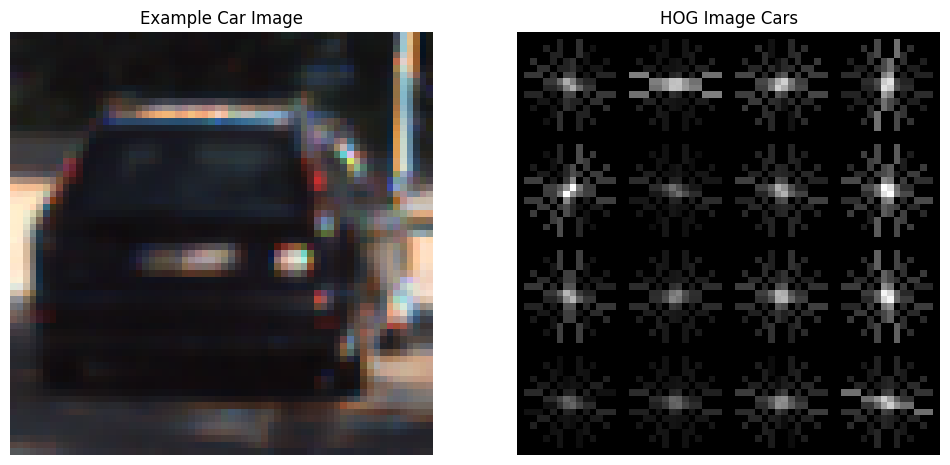

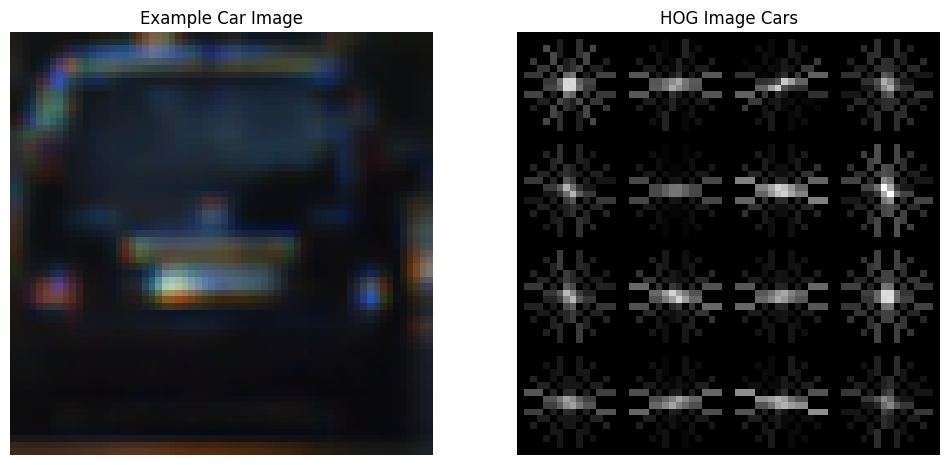

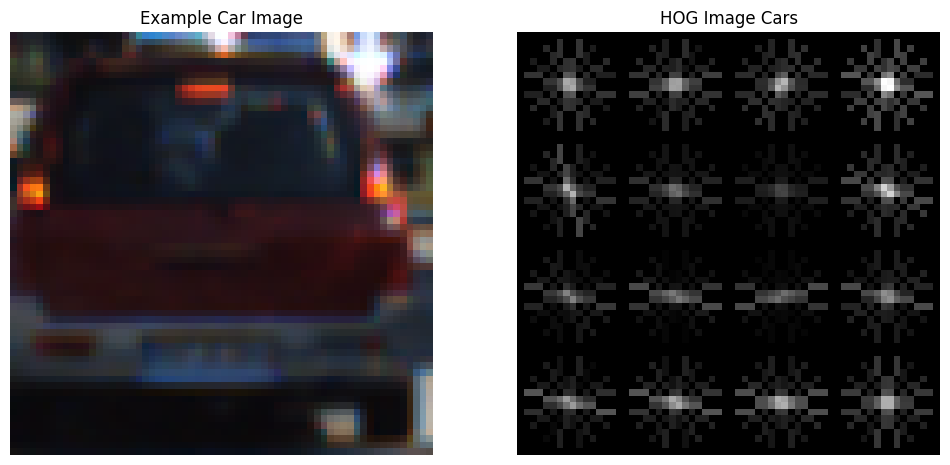

In [9]:
# Hog visualization for car images
images_for_features = list (car_images [:3])

feature_examples = []
feature_examples.extend (images_for_features)


for im in images_for_features:
    features, hog_image = get_hog_features(get_s_from_hls(im), orient, pix_per_cell, cell_per_block, vis=True)
    feature_examples.append (hog_image)
    fig = plt.figure(figsize=(12,10))
    plt.subplot(1,2,1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    plt.title('Example Car Image')

    plt.subplot(1,2,2)
    plt.imshow(hog_image,cmap='gray')
    plt.title('HOG Image Cars')
    plt.axis('off')
    plt.show()

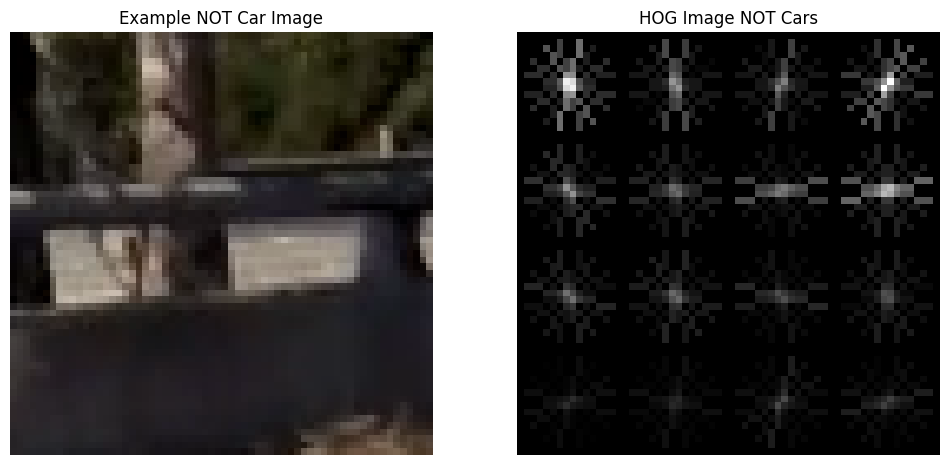

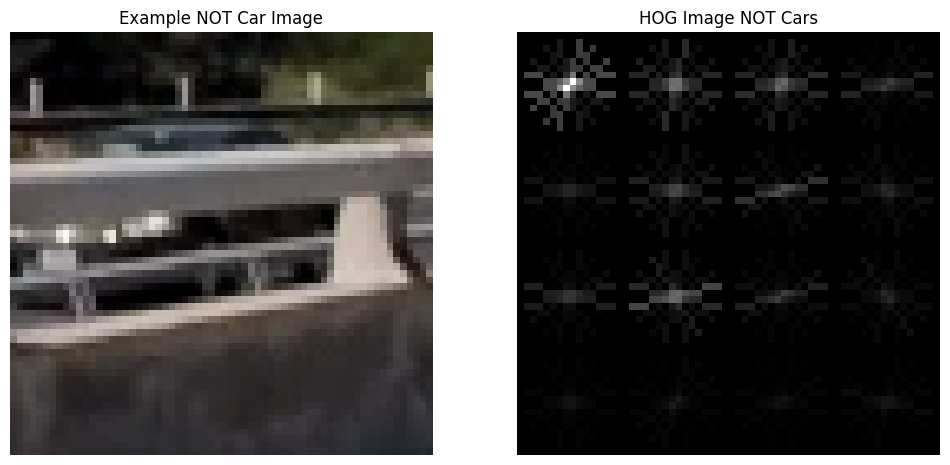

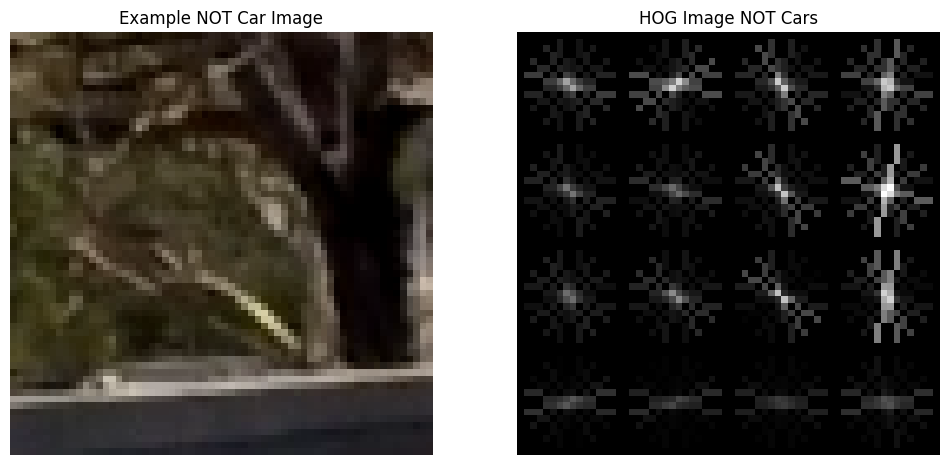

In [10]:
# Hog visualization for Non car images
images_for_features = list (non_car_images [:3])

feature_examples = []
feature_examples.extend (images_for_features)


for im in images_for_features:
    features, hog_image = get_hog_features(get_s_from_hls(im), orient, pix_per_cell, cell_per_block, vis=True)
    feature_examples.append (hog_image)
    fig = plt.figure(figsize=(12,10))
    plt.subplot(1,2,1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    plt.title('Example NOT Car Image')

    plt.subplot(1,2,2)
    plt.imshow(hog_image,cmap='gray')
    plt.title('HOG Image NOT Cars')
    plt.axis('off')
    plt.show()

In [11]:
# Define a function to return some characteristics of the dataset
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    car_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = car_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = car_img.dtype
    # Return data_dict
    return data_dict

In [12]:
def visualize_images(input_images, num_cols, figure_name, cmap = None):
    "Shows input images by stacking them in num_cols columns"
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.manager.set_window_title(figure_name)

    print(figure_name)

    for ax, image in zip(axes.flat, input_images):
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()

In [13]:
import glob

#Read cars and not-cars images

#Data folders
vehicles_dir =     '/content/drive/MyDrive/videoAnalytics/data/vehicles/'
non_vehicles_dir = '/content/drive/MyDrive/videoAnalytics/data/non-vehicles/'

# images are divided up into vehicles and non-vehicles
cars = []
notcars = []

# Read vehicle images
images = glob.iglob(vehicles_dir + '/**/*.png', recursive=True)

for image in images:
        cars.append(image)

# Read non-vehicle images
images = glob.iglob(non_vehicles_dir + '/**/*.png', recursive=True)

for image in images:
        notcars.append(image)

data_info = data_look(cars, notcars)

print('Your function returned a count of',
      data_info["n_cars"], ' cars and',
      data_info["n_notcars"], ' not-cars')
print('of size: ',data_info["image_shape"], ' and data type:',
      data_info["data_type"])

Your function returned a count of 8792  cars and 8968  not-cars
of size:  (64, 64, 3)  and data type: float32


Example Car images


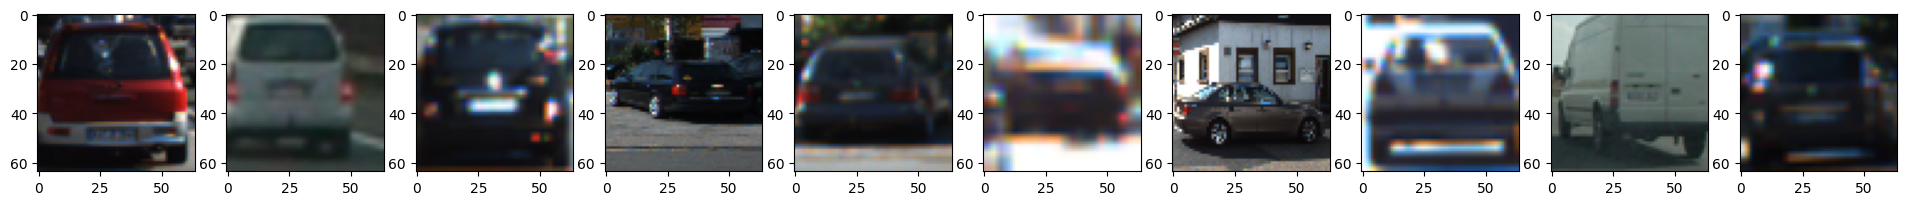

Example not-car images


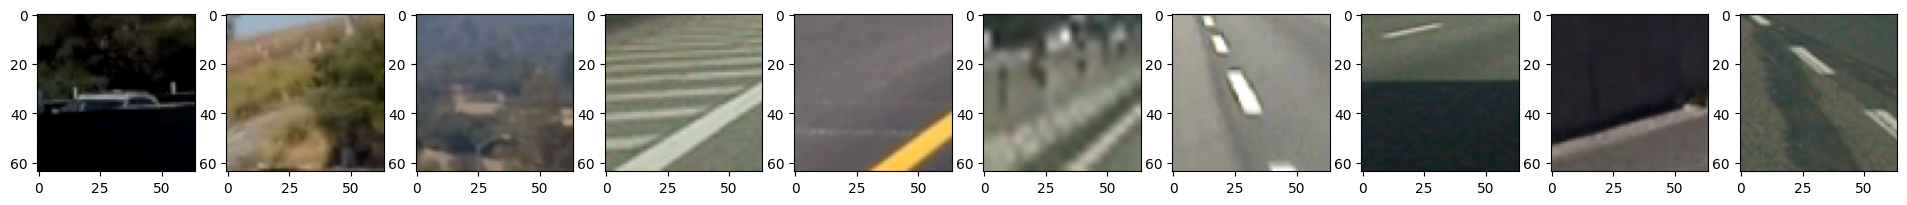

In [14]:
#Visualize some input images
import random

num_images = 10

# Just for fun choose random car / not-car indices and plot example images
cars_samples = random.sample(list(cars), num_images)
notcar_samples = random.sample(list(notcars), num_images)

# Read in car / not-car images
car_images = []
notcar_images = []
for sample in cars_samples:
    car_images.append(mpimg.imread(sample))

for sample in notcar_samples:
    notcar_images.append(mpimg.imread(sample))

visualize_images(car_images, num_images, "Example Car images")
visualize_images(notcar_images, num_images, "Example not-car images")

# hog_features for all images

In [15]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """Extract spatial, color and hog features from specified list of images
    Args:
        imgs (list): list of images in RGB format
        color_space: GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
        spatial_size (tuple): resize img before calculating spatial features
            default value is (32, 32)
        hist_bins (int): number of histogram bins, 32 by default
        orient (int): number of HOG orientations
        pix_per_cell (int): number of pixels in HOG cell
        cell_per_block (int): number of HOG cells in block
        hog_channel (int): channel to use for HOG features calculating, default 0
        spatial_feat (boolean): calculate spatial featues, default True
        hist_feat (boolean): calculate histogram featues, default True
        hog_feat (boolean): calculate HOG featues, default True
    Returns:
        features_vector (numpy.array)
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor (image, getattr(cv2, 'COLOR_RGB2' + color_space))
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if color_space == 'GRAY':
                hog_features = get_hog_features(feature_image, orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            elif hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [16]:
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print ('result dataset:', len(car_image), 'cars /', len(notcar_image), 'not cars')

ft=time.time()
car_features = extract_features(car_image, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_image, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
ft2=time.time()
print ('features extraction time: ', round(ft2-ft, 2))

result dataset: 8792 cars / 8968 not cars
features extraction time:  16.87


In [27]:
car_hog_features = np.array(car_features)
notcar_hog_features = np.array(notcar_features)

In [28]:
print(car_hog_features.shape , notcar_hog_features.shape)

(8792, 128) (8968, 128)


# extract cnn features

In [29]:
car_image[0].shape

(64, 64, 3)

In [30]:
# import tensorflow as tf
# from keras import layers, models

# # Define the CNN model
# model = models.Sequential()

# # Add Convolutional layers
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# # Flatten the output and add Dense layers for classification
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))

# # Output layer with appropriate number of units for your task (e.g., binary or multi-class classification)
# model.add(layers.Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Display the model summary
# model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 128)        

In [31]:
# Assign labels: 1 for cars, 0 for not-cars
car_labels = np.ones(len(car_image))
notcar_labels = np.zeros(len(notcar_image))

# Concatenate car and not-car images and labels
all_images = np.concatenate((car_image, notcar_image))
all_labels = np.concatenate((car_labels, notcar_labels))

In [32]:
all_images.shape, all_labels.shape

((17760, 64, 64, 3), (17760,))

In [33]:
# Split the dataset into training and testing sets
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train_cnn, X_test_cnn = X_train_cnn / 255.0, X_test_cnn / 255.0

In [34]:
import tensorflow as tf
from keras import layers, models

# Define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_cnn, y_train_cnn, epochs=10, validation_data=(X_test_cnn, y_test_cnn))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cnn)
print(f'Test accuracy: {test_acc}')

# Save the trained model
model.save('car_classifier_model.h5')

Epoch 1/10
444/444 [==============================] - 5s 7ms/step - loss: 0.4348 - accuracy: 0.7770 - val_loss: 0.2579 - val_accuracy: 0.8927
Epoch 2/10
444/444 [==============================] - 3s 7ms/step - loss: 0.2122 - accuracy: 0.9123 - val_loss: 0.1785 - val_accuracy: 0.9248
Epoch 3/10
444/444 [==============================] - 3s 8ms/step - loss: 0.1703 - accuracy: 0.9332 - val_loss: 0.1605 - val_accuracy: 0.9381
Epoch 4/10
444/444 [==============================] - 3s 6ms/step - loss: 0.1407 - accuracy: 0.9466 - val_loss: 0.1431 - val_accuracy: 0.9445
Epoch 5/10
444/444 [==============================] - 3s 6ms/step - loss: 0.1190 - accuracy: 0.9545 - val_loss: 0.1286 - val_accuracy: 0.9496
Epoch 6/10
444/444 [==============================] - 3s 6ms/step - loss: 0.1084 - accuracy: 0.9583 - val_loss: 0.0988 - val_accuracy: 0.9589
Epoch 7/10
444/444 [==============================] - 3s 6ms/step - loss: 0.0955 - accuracy: 0.9664 - val_loss: 0.1015 - val_accuracy: 0.9617
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 6, 6, 128)        

In [37]:
from tensorflow.keras.preprocessing import image as I
from tensorflow.keras.models import Model
import numpy as np
import os


# Load the trained model
trained_model = tf.keras.models.load_model('car_classifier_model.h5')

# Create a feature extraction model
feature_extraction_model = models.Model(inputs=trained_model.input,
                                        outputs=trained_model.get_layer('flatten_3').output)

# Example: Extract features from an image
# Replace 'path_to_image.jpg' with the path to your image
image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/videoAnalytics/data/vehicles/GTI_Far/image0000.png', target_size=(64, 64))
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)  # Add batch dimension

# Normalize pixel values to be between 0 and 1
image_array = image_array / 255.0

# Extract features
features = feature_extraction_model.predict(image_array)

# 'features' now contains the features extracted from the Flatten layer
print(features.shape)

1/1 [==============================] - 1s 866ms/step
(1, 4608)


In [38]:
def preprocess_image(img_path):
    img = I.load_img(img_path, target_size=(64, 64))
    img_array = I.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # img_array = preprocess_input(img_array)
    # Normalize pixel values to be between 0 and 1
    img_array = img_array / 255.0
    return img_array

def extract_cnn_features(model, folder_path):
    images = glob.iglob(folder_path + '/**/*.png', recursive=True)

    list_ = [image for image in images]

    features_list = []
    for img_path in list_:
      img_array = preprocess_image(img_path)
      cnn_features = model.predict(img_array)
      features_list.append(cnn_features.flatten())
    return np.array(features_list)

##Load the saved cnn model and the cnn features for training

In [41]:
# Load variables back from the file
pickle_file_path = '/content/drive/MyDrive/videoAnalytics/variables/variables.p'
with open(pickle_file_path, 'rb') as file:
  loaded_dict = pickle.load(file)

In [42]:
loaded_dict

{'feature_extraction_model': <keras.src.engine.functional.Functional at 0x7d8e2a27b400>,
 'car_cnn_features': array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [ 0.      ,  0.      ,  9.811742, ...,  0.      ,  0.      ,
         12.852488],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]], dtype=float32),
 'notcar_cnn_features': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}

In [ ]:
car_folder_path = '/content/drive/MyDrive/videoAnalytics/data/vehicles/'
notcar_folder_path = '/content/drive/MyDrive/videoAnalytics/data/non-vehicles/'

car_cnn_features = extract_cnn_features(feature_extraction_model, car_folder_path)
notcar_cnn_features = extract_cnn_features(feature_extraction_model, notcar_folder_path)

In [ ]:
import pickle

pickle_file_path = '/content/drive/MyDrive/videoAnalytics/variables/variables.p'

cnn_dict = {
    'feature_extraction_model' : feature_extraction_model,
    'car_cnn_features' : car_cnn_features,
    'notcar_cnn_features' : notcar_cnn_features
}

# Save variables to a file using pickle
with open(pickle_file_path, 'wb') as file:
  pickle.dump(cnn_dict, file)

using PCA

In [ ]:
# from sklearn.decomposition import PCA

# # Réduction de dimensionnalité du vecteur CNN VGG16 à 128 dimensions
# pca = PCA(n_components=128)
# car_cnn_features = pca.fit_transform(car_cnn_features)
# notcar_cnn_features = pca.fit_transform(notcar_cnn_features)

In [43]:
car_cnn_features = loaded_dict['car_cnn_features']
notcar_cnn_features = loaded_dict['notcar_cnn_features']

using Dense

# concatenation

In [44]:
car_features= np.concatenate((car_hog_features,car_cnn_features), axis=1)
notcar_features=np.concatenate((notcar_hog_features,notcar_cnn_features), axis=1)

In [45]:
print("the shape of vector descriptor(HOG+CNN) of car_features",car_features.shape)
print("the shape of vector descriptor(HOG+CNN) of not_car_features",notcar_features.shape)

the shape of vector descriptor(HOG+CNN) of car_features (8792, 4736)
the shape of vector descriptor(HOG+CNN) of not_car_features (8968, 4736)


Feature Normalization


In [46]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [ ]:
# from sklearn.decomposition import PCA

# # Réduction de dimensionnalité du vecteur CNN VGG16 à 128 dimensions
# pca = PCA(n_components=4000)
# X_pca = pca.fit_transform(scaled_X)

In [ ]:
# #### without CNN
# X = np.vstack((car_features_array, notcar_features_array)).astype(np.float64)
# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
# scaled_X = X_scaler.transform(X)

# # Define the labels vector
# y = np.hstack((np.ones(len(car_features_array)), np.zeros(len(notcar_features_array))))

In [47]:
len(car_features)

8792

Randomize a selection for training and testing


In [48]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 8 orientations 16 pixels per cell and 1 cells per block
Feature vector length: 4736


In [49]:
# I use default rbf kernel SVM
svc = SVC ()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Test Accuracy of SVC =  0.9718


In [50]:
print("accuracy :",round(svc.score(X_test, y_test), 4)*100,"%")

accuracy : 97.18 %


# Sliding Window Implementation to Search and Classify


In [ ]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """Draws windows or bounding boxes on the image
    Args:
        img (numpy.array): image to search
        bboxes (list): bounding boxes
        color (tuple): bounding box color, default is (0, 0, 255)
        thick (int): thickness of bounding box, default is 6 pixels
    Returns:
        image copy with boxes drawn
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """Create and return sliding window lattice as list of sliding windows
    Args:
        img (numpy.array): image to search
        x_start_stop (list): horizontal limits, if [None, None] then [0, image width]  will be used
        y_start_stop (list): vertical   limits, if [None, None] then [0, image height] will be used
        xy_window (tuple): sliding window size, default is (64, 64)
        xy_overlap (tuple): sliding window overlap factor, default is (0.5, 0.5)
    Returns:
        list of windows
    """
    # If x and/or y start/stop positions not defined, set to image size
    imgsizey = img.shape [0]
    imgsizex = img.shape [1]
    x_start_stop [0] = 0 if x_start_stop [0] is None else x_start_stop [0]
    x_start_stop [1] = imgsizex if x_start_stop [1] is None else x_start_stop [1]
    y_start_stop [0] = 0 if y_start_stop [0] is None else y_start_stop [0]
    y_start_stop [1] = imgsizey if y_start_stop [1] is None else y_start_stop [1]
    # Compute the span of the region to be searched
    sizex = x_start_stop [1] - x_start_stop [0]
    sizey = y_start_stop [1] - y_start_stop [0]
    # Compute the number of pixels per step in x/y
    stepx = int (xy_window [0] * xy_overlap [0])
    stepy = int (xy_window [1] * xy_overlap [1])
    # Compute the number of windows in x/y
    step_count_x = int (math.floor(1.0 * sizex / stepx)) - 1
    step_count_y = int (math.floor(1.0 * sizey / stepy)) - 1
    # Initialize a list to append window positions to
    window_list = []
    for i in range (step_count_y):
        for j in range (step_count_x):
            # Calculate each window position
            # Append window position to list
            window_list.append ((
                (x_start_stop [0] + j*stepx, y_start_stop [0] + i*stepy),
                (x_start_stop [0] + j*stepx + xy_window [0], y_start_stop [0] + i*stepy + xy_window [1])
                ))
    # Return the list of windows
    return window_list

In [ ]:
!unzip /content/drive/MyDrive/videoAnalytics/data/test_images-20240114T142949Z-001.zip -d /content/drive/MyDrive/videoAnalytics/data/

In [ ]:
# defining parameters of sliding windows
# I use 3 sliding windows with different sizes, and different positions

image = mpimg.imread('/content/drive/MyDrive/videoAnalytics/data/test_images/test1.jpg')
window_img = np.copy(image)

sw_x_limits = [
    [None, None],
    [32, None],
    [412, 1280]
]

sw_y_limits = [
    [400, 640],
    [400, 600],
    [390, 540]
]

sw_window_size = [
    (128, 128),
    (96, 96),
    (80, 80)
]

sw_overlap = [
    (0.5, 0.5),
    (0.5, 0.5),
    (0.5, 0.5)
]

# create sliding windows
windows = slide_window(image, x_start_stop=sw_x_limits[0], y_start_stop=sw_y_limits[0],
                    xy_window=sw_window_size[0], xy_overlap=sw_overlap[0])

windows2 = slide_window(image, x_start_stop=sw_x_limits[1], y_start_stop=sw_y_limits[1],
                    xy_window=sw_window_size[1], xy_overlap=sw_overlap[1])

windows3 = slide_window(image, x_start_stop=sw_x_limits[2], y_start_stop=sw_y_limits[2],
                    xy_window=sw_window_size[2], xy_overlap=sw_overlap[2])

# show sliding windows
sliding_windows = []
sliding_windows.append (draw_boxes(np.copy(image), windows, color=(0, 0, 0), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows2, color=(0, 0, 0), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows3, color=(0, 0, 0), thick=4))

# drawing one of sliding windows in blue
sliding_windows [0] = draw_boxes (sliding_windows [0], [windows[9]], color=(0, 0, 255), thick=8)
sliding_windows [1] = draw_boxes (sliding_windows [1], [windows2[12]], color=(0, 0, 255), thick=8)
sliding_windows [2] = draw_boxes (sliding_windows [2], [windows3[5]], color=(0, 0, 255), thick=8)

sw_titles = [
    '128 x 128 windows',
    '96 x 96',
    '80 x 80'
]

show_images_in_table (sliding_windows, (3, 1), fig_size=(20, 14), titles=sw_titles)

In [ ]:
cnn_model = loaded_dict['feature_extraction_model']

In [ ]:
import tensorflow as tf
def get_hot_boxes (image, image_path):
    """Applies sliding windows to images
    and finds hot windows. Also returns image with all hot boxes are drawn
    Args:
        image (numpy.array): image
    Returns:
        hot_windows(list), image_with_hot_windows_drawn(numpy.array)
    """

    dst = np.copy (image)
    all_hot_windows = []

    # iterate over previousely defined sliding windows
    for x_limits, y_limits, window_size, overlap in zip (sw_x_limits, sw_y_limits, sw_window_size, sw_overlap):

        windows = slide_window(
            dst,
            x_start_stop=x_limits,
            y_start_stop=y_limits,
            xy_window=window_size,
            xy_overlap=overlap
        )

        hot_windows = search_windows(image, image_path, windows, cnn_model, svc, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

        if hot_windows is not None:  # Check if hot_windows is not None before proceeding
            all_hot_windows.extend(hot_windows)
            dst = draw_boxes(dst, hot_windows, color=(0, 0, 1), thick=4)
        else:
            print("Warning: No hot windows found for the current iteration.")

    return all_hot_windows, dst

def get_heat_map(image, bbox_list):
    """Computes heat map of hot windows. Puts all specified
    hot windows on top of each other, so every pixel of returned image will
    contain how many hot windows covers this pixel
    Args:
        image (numpy.array): image
    Returns:
        heatmap (numpy.array) grayscale image of the same size as input image
    """

    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

class AverageHotBox ():
    """Class that covers joining hot boxes algorithm.
    We have many less or more overlapped boxes and we need to
    join it around peaks to convert many overlapped boxes into
    smaller amount of not or slightly overlapped ones.
    Idea is take fist box (called average box) form input boxes
    and join it with all boxes
    that is close enough (here for two boxes:
    they need to overlap by 30% of area of any one of two)
    After joining two boxes we need to update average box (here
    just increasing size to cover both joining boxes).
    Loop while we are able to join futhermore.
    For left boxes repeat all procedure.
    As a result we may also get average boxes strengths, the number of
    boxes it was joined to.
    This class represents one average box.
    """
    def __init__ (self, box):
        self.avg_box = [list(p) for p in box]
        self.detected_count = 1
        self.boxes = [box]

    def get_strength (self):
        """Returns number of joined boxes"""
        return self.detected_count

    def get_box (self):
        """Uses joined boxes information to compute
        this average box representation as hot box.
        This box has average center of all boxes and have
        size of 2 standard deviation by x and y coordinates of its points
        """
        if len(self.boxes) > 1:
            center = np.average (np.average (self.boxes, axis=1), axis=0).astype(np.int32).tolist()

            # getting all x and y coordinates of
            # all corners of joined boxes separately
            xs = np.array(self.boxes) [:,:,0]
            ys = np.array(self.boxes) [:,:,1]

            half_width = int(np.std (xs))
            half_height = int(np.std (ys))
            return (
                (
                    center[0] - half_width,
                    center[1] - half_height
                ), (
                    center[0] + half_width,
                    center[1] + half_height
                ))
        else:
            return self.boxes [0]

    def is_close (self, box):
        """Check wether specified box is close enough for joining
        to be close need to overlap by 30% of area of this box or the average box
        """
        x11 = self.avg_box [0][0]
        y11 = self.avg_box [0][1]
        x12 = self.avg_box [1][0]
        y12 = self.avg_box [1][1]
        x21 = box [0][0]
        y21 = box [0][1]
        x22 = box [1][0]
        y22 = box [1][1]

        x_overlap = max(0, min(x12,x22) - max(x11,x21))
        y_overlap = max(0, min(y12,y22) - max(y11,y21))

        area1 = (x12 - x11) * (y12 - y11)
        area2 = (x22 - x21) * (y22 - y21)
        intersection = x_overlap * y_overlap;

        if (
            intersection >= 0.3 * area1 or
            intersection >= 0.3 * area2
        ):
            return True
        else:
            return False

    def join (self, boxes):
        """Join in all boxes from list of given boxes,
        removes joined boxes from input list of boxes
        """

        joined = False

        for b in boxes:
            if self.is_close (b):
                boxes.remove (b)
                self.boxes.append (b)
                self.detected_count += 1

                self.avg_box [0][0] = min (self.avg_box [0][0], b [0][0])
                self.avg_box [0][1] = min (self.avg_box [0][1], b [0][1])
                self.avg_box [1][0] = max (self.avg_box [1][0], b [1][0])
                self.avg_box [1][1] = max (self.avg_box [1][1], b [1][1])

                joined = True

        return joined

def calc_average_boxes (hot_boxes, strength):
    """Compute average boxes from specified hot boxes and returns
    average boxes with equals or higher strength
    """
    avg_boxes = []
    while len(hot_boxes) > 0:
        b = hot_boxes.pop (0)
        hb = AverageHotBox (b)
        while hb.join (hot_boxes):
            pass
        avg_boxes.append (hb)

    boxes = []
    for ab in avg_boxes:
        if ab.get_strength () >= strength:
            boxes.append (ab.get_box ())
    return boxes

def search_windows(img, image_path, windows, model, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):
    """Apply specified classificator to specified windows
    and returns hot windows - windows classified as holding interesting object
    Args:
        img (numpy.array): image to search
        windows (list): list of coordinates of sliding windows in form of
            ((top left x, top left y), (bottom right x, bottom right y))
        spatial_size (tuple): resize img before calculating spatial features
            default value is (32, 32)
        hist_bins (int): number of histogram bins, 32 by default
        orient (int): number of HOG orientations
        pix_per_cell (int): number of pixels in HOG cell
        cell_per_block (int): number of HOG cells in block
        hog_channel (int): channel to use for HOG features calculating, default 0
        spatial_feat (boolean): calculate spatial featues, default True
        hist_feat (boolean): calculate histogram featues, default True
        hog_feat (boolean): calculate HOG featues, default True
    Returns:
        list of hot windows
    """
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64), interpolation=cv2.INTER_AREA)
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # print(type(img))
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
        # img = cv2.resize(img, (64, 64))
        image_array = tf.keras.preprocessing.image.img_to_array(img)
        image_array = tf.expand_dims(image_array, 0)  # Add batch dimension

        # Normalize pixel values to be between 0 and 1
        image_array = image_array / 255.0

        # Extract features
        cnn_features = cnn_model.predict(image_array)
        test_features = np.concatenate((features.reshape(1, -1), cnn_features), axis=1)
        test_features = scaler.transform(test_features)
        print(test_features.shape)

        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """Extract spatial, color and hog features from single image
    Args:
        img (numpy.array): image in RGB format
        color_space: GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
        spatial_size (tuple): resize img before calculating spatial features
            default value is (32, 32)
        hist_bins (int): number of histogram bins, 32 by default
        orient (int): number of HOG orientations
        pix_per_cell (int): number of pixels in HOG cell
        cell_per_block (int): number of HOG cells in block
        hog_channel (int): channel to use for HOG features calculating, default 0
        spatial_feat (boolean): calculate spatial featues, default True
        hist_feat (boolean): calculate histogram featues, default True
        hog_feat (boolean): calculate HOG featues, default True
    Returns:
        features_vector (list(numpy.array)): list of feature vectors
    """
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = cv2.cvtColor (img, getattr(cv2, 'COLOR_RGB2' + color_space))
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if color_space == 'GRAY':
            hog_features = get_hog_features(feature_image, orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        elif hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [ ]:
# algorithm demonstration on test images

test_images = []
test_images_titles = []

for impath in glob.glob('/content/drive/MyDrive/videoAnalytics/data/test_images/test*.jpg'):
    image_orig = mpimg.imread(impath)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image_orig.astype(np.float32)/255

    # hot boxes
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image, impath)
    # heat map
    heat_map = get_heat_map (image, hot_boxes)

    # average boxes
    avg_boxes = calc_average_boxes (hot_boxes, 2)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)

    test_images.append (image_with_hot_boxes)
    test_images.append (heat_map)
    test_images.append (image_with_boxes)

    test_images_titles.extend (['', '', ''])

test_images_titles [0] = 'hot boxes'
test_images_titles [1] = 'heat map'
test_images_titles [2] = 'average boxes'

show_images_in_table (test_images, (3, 6), fig_size=(20, 24), titles=test_images_titles)

# Implementation with video

In [ ]:
# in video I use information from multiple frames to
# make average boxes more robust and filter false positives
# I accumulate all hot boxes from last several frames and use them
# for calculating average boxes

class LastHotBoxesQueue ():
    """Class for accumulation of hot boxes from last 10 frames
    """
    def __init__ (self):
        self.queue_max_len = 10 # number items to store
        self.last_boxes = []

    def put_hot_boxes (self, boxes):
        """Put frame hot boxes
        """
        if (len(self.last_boxes) > self.queue_max_len):
            tmp = self.last_boxes.pop (0)

        self.last_boxes.append (boxes)

    def get_hot_boxes (self):
        """Get last 10 frames hot boxes
        """
        b = []
        for boxes in self.last_boxes:
            b.extend (boxes)
        return b

last_hot_boxes = LastHotBoxesQueue ()

def process_image (image_orig):

    image_orig = np.copy (image_orig)
    image = image_orig.astype(np.float32)/255

    # accumulating hot boxes over 10 last frames
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image, image_path)
    last_hot_boxes.put_hot_boxes (hot_boxes)
    hot_boxes = last_hot_boxes.get_hot_boxes ()

    # calculating average boxes and use strong ones
    # need to tune strength on particular classifer
    avg_boxes = calc_average_boxes (hot_boxes, 20)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)

    return image_with_boxes * 255

In [ ]:
from moviepy.editor import VideoFileClip

def process_video (input_path, output_path):
    clip = VideoFileClip (input_path)

    result = clip.fl_image (process_image)
    %time result.write_videofile (output_path)

# select video to operate on
process_video ('/content/drive/MyDrive/videoAnalytics/data/test_video.mp4', '/content/drive/MyDrive/videoAnalytics/data/test_video_result.mp4')

In [ ]:
model.train()